## Getting data

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 18.6 MB/s 
     |████████████████████████████████| 6.6 MB 6.7 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [ ]:
from google.colab import drive
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import codecs
drive.mount('/content/gdrive')
LYRICS_DIR = '/content/gdrive/MyDrive/raw_lyrics/'

Mounted at /content/gdrive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/song_list.csv')

In [ ]:
data.head()

,Index,Artist,Title,Mood
0,ML1,Usher,There Goes My Baby,relaxed
1,ML2,Da'Ville,On My Mind,relaxed
2,ML3,Rihanna,Rockstar 101,relaxed
3,ML4,J. Holiday,Bed,relaxed
4,ML5,Morgan Heritage,Don't Haffi Dread,angry


In [ ]:
data['lyrics'] = ""
data = data.set_index('Index')
data

,Artist,Title,Mood,lyrics
Index,,,,
ML1,Usher,There Goes My Baby,relaxed,
ML2,Da'Ville,On My Mind,relaxed,
ML3,Rihanna,Rockstar 101,relaxed,
ML4,J. Holiday,Bed,relaxed,
ML5,Morgan Heritage,Don't Haffi Dread,angry,
...,...,...,...,...
ML2591,Slayer,Fight Till Death,angry,
ML2592,Anthrax,Among the Living,angry,
ML2593,Opeth,Heir Apparent,sad,


In [ ]:
texts_ids = []


def load_lyrics():
    lyrics_list = []
    for filename in os.listdir(LYRICS_DIR):
        texts_ids.append(filename[:-4])
        with codecs.open(LYRICS_DIR+ filename, 'r') as f:
            buff = f.read()
            lyrics_list.append(buff)
            data.at[filename[:-4], 'lyrics'] = buff

    return lyrics_list

In [ ]:
load_lyrics()

["I built my wall\nYou walked right through it\nI threw my stone\nYou leaned into it\n\nYou were the only one to show me hell\nYou rescued my soul, shattered my shell\nYou were the only spot not petrified\nSaid the right things at the right time\n\nYou love me, love me, love me\nYou love me, love me, love me, love me now\n\nYou light my fuse\nI won't blow it\nAnd these games you use\nDo you think I don't know it?\n\nYou were the only one to show me hell\nYou rescued my soul, shattered my shell\nYou were the only spot not petrified\nSaid the right things at the right time\n\nYou love me, love me, love me\nYou love me, love me, love me, love me now\nLove me, love me now\n\nMy eyes don't belong, across from your stare\nI'm not going home, and you're not going anywhere\n\nYou love me, love me, love me\nYou love me, love me, love me, love me now\n\nYou love me, love me, love me\nYou love me, love me, love me, love me now\n\nLove me now\nLove me now\nLove me now\nLove me now",
 "Birds flyin'

In [ ]:
relaxed_count = data[data.Mood == "relaxed"].shape[0]
angry_count = data[data.Mood == "angry"].shape[0]
happy_count = data[data.Mood == "happy"].shape[0]
sad_count = data[data.Mood == "sad"].shape[0]

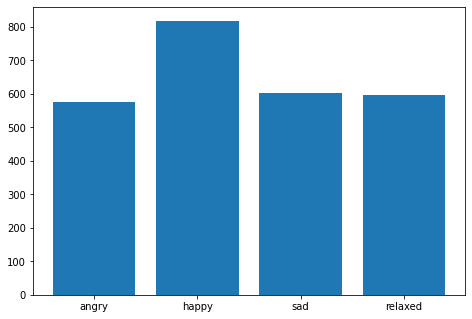

In [ ]:
import matplotlib.pyplot as plt
fig  = plt.figure()
ax = fig.add_axes([0,0,1,1])
moods = ["angry", "happy", "sad", "relaxed"]
counts = [angry_count, happy_count, sad_count, relaxed_count]
ax.bar(moods, counts)
plt.show()

In [ ]:
data

,Artist,Title,Mood,lyrics
Index,,,,
ML1,Usher,There Goes My Baby,relaxed,There goes my baby\n(Ooh girl look at you)\nYo...
ML2,Da'Ville,On My Mind,relaxed,I'm thinking about you\nGirl I miss you\nBaby ...
ML3,Rihanna,Rockstar 101,relaxed,I told ya\nI told ya\nI told ya\nBaby\nBaby\n\...
ML4,J. Holiday,Bed,relaxed,(J. Holiday: speaking)\nJ. Holiday\nL.O.S.\nAy...
ML5,Morgan Heritage,Don't Haffi Dread,angry,"Yeah, yeah, yeah - ragga so ragga\n\nYou don't..."
...,...,...,...,...
ML2591,Slayer,Fight Till Death,angry,Metal and men clash once more to the end\nWarr...
ML2592,Anthrax,Among the Living,angry,"Disease, disease\nSpreading the disease\nWith ..."
ML2593,Opeth,Heir Apparent,sad,Slow days\nSlow words\nSlow lies\nSlow ends\n\...


In [ ]:
# data.loc[data.Mood == "happy", "Mood"] = 1
# data.loc[data.Mood == "relaxed", "Mood"] = 2
# data.loc[data.Mood == "sad", "Mood"] = 3
# data.loc[data.Mood == "angry", "Mood"] = 4

for index, row in data.iterrows():
    if row["Mood"] == "happy":
        data.at[index, "Mood"] = [1,0,0,0]
    elif row["Mood"] == "relaxed":
        data.at[index, "Mood"] = [0,1,0,0]
    elif row["Mood"] == "sad":
        data.at[index, "Mood"] = [0,0,1,0]
    elif row["Mood"] == "angry":
        data.at[index, "Mood"] = [0,0,0,1]

data

,Artist,Title,Mood,lyrics
Index,,,,
ML1,Usher,There Goes My Baby,"[0, 1, 0, 0]",There goes my baby\n(Ooh girl look at you)\nYo...
ML2,Da'Ville,On My Mind,"[0, 1, 0, 0]",I'm thinking about you\nGirl I miss you\nBaby ...
ML3,Rihanna,Rockstar 101,"[0, 1, 0, 0]",I told ya\nI told ya\nI told ya\nBaby\nBaby\n\...
ML4,J. Holiday,Bed,"[0, 1, 0, 0]",(J. Holiday: speaking)\nJ. Holiday\nL.O.S.\nAy...
ML5,Morgan Heritage,Don't Haffi Dread,"[0, 0, 0, 1]","Yeah, yeah, yeah - ragga so ragga\n\nYou don't..."
...,...,...,...,...
ML2591,Slayer,Fight Till Death,"[0, 0, 0, 1]",Metal and men clash once more to the end\nWarr...
ML2592,Anthrax,Among the Living,"[0, 0, 0, 1]","Disease, disease\nSpreading the disease\nWith ..."
ML2593,Opeth,Heir Apparent,"[0, 0, 1, 0]",Slow days\nSlow words\nSlow lies\nSlow ends\n\...


Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

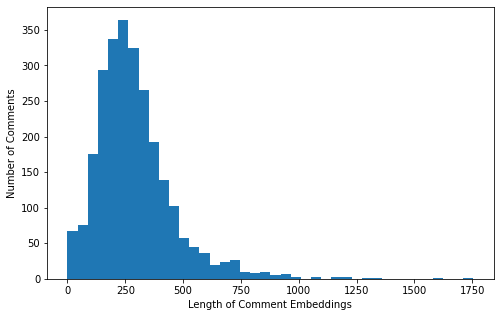

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
    
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
tokenized_lyrics = data['lyrics'].values

plot_sentence_embeddings_length(tokenized_lyrics, tokenizer)


Since most songs have less than 350 words we can truncate or pad all songs to 350 sub-words

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [ ]:
tokenized_data = tokenize_inputs(data['lyrics'].values,tokenizer, 350)

In [ ]:
tokenized_data

array([[ 105, 1565,   94, ...,   44,    4,    3],
       [  17,  150,   26, ...,    0,    0,    0],
       [  17,  150,  258, ...,   94,    4,    3],
       ...,
       [2208,  307, 2208, ...,    0,    0,    0],
       [4027,  326, 9376, ...,    0,    0,    0],
       [3353,   17,  529, ...,    0,    0,    0]])

In [ ]:
test_nb = round(2571*0.2)
train_nb = 2571 - test_nb
test_input_ids = tokenized_data[:test_nb]
train_input_ids = tokenized_data[test_nb:]

In [ ]:
test_data = data.loc["ML1":f"ML{test_nb}", :]
train_data = data.loc[f"ML{test_nb+1}":, :]

In [ ]:
train_data

,Artist,Title,Mood,lyrics
Index,,,,
ML515,John Coltrane,Acknowledgement,"[1, 0, 0, 0]","A love supreme,\nA love supreme,\nA love supre..."
ML516,Seether,Driven Under,"[0, 0, 0, 1]",Do you think I'm faking\nWhen I'm lying next t...
ML517,Soundgarden,Rhinosaur,"[0, 0, 1, 0]",Standing with my enemies\nHung on my horns\nWi...
ML518,Metallica,Fight Fire With Fire,"[0, 0, 0, 1]",Do unto others as they've done to you\nBut wha...
ML519,Deftones,You've Seen the Butcher,"[0, 0, 1, 0]",Don't wanna take it slow\nI wanna take you hom...
...,...,...,...,...
ML2591,Slayer,Fight Till Death,"[0, 0, 0, 1]",Metal and men clash once more to the end\nWarr...
ML2592,Anthrax,Among the Living,"[0, 0, 0, 1]","Disease, disease\nSpreading the disease\nWith ..."
ML2593,Opeth,Heir Apparent,"[0, 0, 1, 0]",Slow days\nSlow words\nSlow lies\nSlow ends\n\...


In [ ]:
def create_attn_masks(input_ids):

    attention_masks = []

    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks
    
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

In [ ]:
len(train_input_ids)

2081

In [ ]:
train_input_ids

array([[   24,   564, 12077, ...,     0,     0,     0],
       [  112,    44,   232, ...,   137,     4,     3],
       [ 2177,    33,    94, ...,     0,     0,     0],
       ...,
       [ 2208,   307,  2208, ...,     0,     0,     0],
       [ 4027,   326,  9376, ...,     0,     0,     0],
       [ 3353,    17,   529, ...,     0,     0,     0]])

In [ ]:
len(train_data) + len(test_data)

2595

In [ ]:
train_data["features"] = train_input_ids.tolist()
train_data["masks"] = train_attention_masks

test_data["features"] = test_input_ids.tolist()
test_data["masks"] = test_attention_masks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
train_data

,Artist,Title,Mood,lyrics,features,masks
Index,,,,,,
ML515,John Coltrane,Acknowledgement,"[1, 0, 0, 0]","A love supreme,\nA love supreme,\nA love supre...","[24, 564, 12077, 19, 24, 564, 12077, 19, 24, 5...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
ML516,Seether,Driven Under,"[0, 0, 0, 1]",Do you think I'm faking\nWhen I'm lying next t...,"[112, 44, 232, 17, 150, 26, 98, 17, 2819, 2082...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
ML517,Soundgarden,Rhinosaur,"[0, 0, 1, 0]",Standing with my enemies\nHung on my horns\nWi...,"[2177, 33, 94, 6989, 6699, 31, 94, 19907, 33, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
ML518,Metallica,Fight Fire With Fire,"[0, 0, 0, 1]",Do unto others as they've done to you\nBut wha...,"[112, 10353, 538, 34, 63, 26, 189, 588, 22, 44...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
ML519,Deftones,You've Seen the Butcher,"[0, 0, 1, 0]",Don't wanna take it slow\nI wanna take you hom...,"[220, 26, 46, 20424, 182, 36, 2208, 17, 150, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...
ML2591,Slayer,Fight Till Death,"[0, 0, 0, 1]",Metal and men clash once more to the end\nWarr...,"[2568, 21, 416, 9169, 497, 70, 22, 18, 239, 16...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
ML2592,Anthrax,Among the Living,"[0, 0, 0, 1]","Disease, disease\nSpreading the disease\nWith ...","[1487, 19, 1487, 9240, 18, 1487, 33, 106, 222,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
ML2593,Opeth,Heir Apparent,"[0, 0, 1, 0]",Slow days\nSlow words\nSlow lies\nSlow ends\n\...,"[2208, 307, 2208, 1006, 2208, 3516, 2208, 4150...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
train, valid = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
train["features"]

Index
ML2574    [442, 24, 1615, 113, 85, 603, 22, 39, 85, 42, ...
ML1195    [17, 150, 220, 26, 46, 175, 160, 17, 150, 4632...
ML2018    [73, 713, 20, 813, 20872, 758, 20, 3085, 57, 1...
ML1261    [1622, 4903, 22, 44, 1622, 4903, 22, 44, 1622,...
ML998     [345, 24, 4467, 31, 18, 587, 814, 17, 150, 30,...
                                ...                        
ML2153    [85, 121, 47, 54, 107, 71, 838, 26, 46, 17, 15...
ML1610    [2609, 55, 4426, 1012, 90, 80, 1133, 18, 546, ...
ML1645    [808, 14171, 19, 8303, 19, 17, 1258, 617, 19, ...
ML1809    [829, 18, 571, 21, 216, 192, 17, 150, 5632, 19...
ML1375    [259, 18, 5641, 59, 3028, 65, 878, 6051, 21, 2...
Name: features, Length: 1664, dtype: object

In [ ]:
X_train = torch.tensor(train["features"])
X_valid = torch.tensor(valid["features"])

Y_train = torch.tensor(train["Mood"], dtype=torch.float32)
Y_valid = torch.tensor(valid["Mood"], dtype=torch.float32)

train_masks = torch.tensor(train["masks"], dtype=torch.long)
valid_masks = torch.tensor(valid["masks"], dtype=torch.long)

In [ ]:
batch_size = 4

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## Loading the model

In [ ]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state


model = XLNetForMultiLabelSequenceClassification(num_labels=4)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training model on our dataset

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):

  model.to(device)

  for i in trange(num_epochs, desc="Epoch"):
    actual_epoch = start_epoch + i

    model.train()

    tr_loss = 0
    num_train_samples = 0

    for step, batch in enumerate(train_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      optimizer.zero_grad()
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      loss.backward()
      optimizer.step()

    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    model.eval()

    eval_loss = 0
    num_eval_samples = 0

    for batch in valid_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  print(save_path)
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:

print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80


In [ ]:
from os.path import exists
exists(model_save_path)

True

In [ ]:
num_epochs = 2
cwd = os.getcwd()
model_save_path = output_model_file = "/content/gdrive/MyDrive/Models/xlnet_emotions.bin"
model, train_loss_set, valid_loss_set = train(model = model,
                                              num_epochs = num_epochs,
                                              optimizer = optimizer,
                                              train_dataloader = train_dataloader,
                                              valid_dataloader = validation_dataloader,
                                              model_save_path = model_save_path,
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.01131940788415793
Valid loss: 0.03214912504606547
/content/gdrive/MyDrive/Models/xlnet_emotions.bin


Epoch:  50%|█████     | 1/2 [06:13<06:13, 373.41s/it]

Saving model at epoch 0 with validation loss of 0.03214912504606547


Train loss: 0.008427377527543838


Epoch: 100%|██████████| 2/2 [12:25<00:00, 372.65s/it]

Valid loss: 0.05275636208768514




In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs
  
num_labels = 4
pred_probs = generate_predictions(model, test_data, num_labels, device="cuda", batch_size=32)

In [ ]:
predicted_emotion = np.round(pred_probs)

In [ ]:
len(predicted_emotion)

514

In [ ]:
len(test_data["Mood"])

514

In [ ]:
predicted_emotion[0]

array([0., 1., 0., 0.])

In [ ]:
correctly_predicted = []
incorrect = []
sad_count = 0
happy_count = 0
relaxed_count = 0
angry_count = 0

for index,emotion in enumerate(test_data["Mood"]):
    if (emotion == predicted_emotion[index]).all():
        if emotion == [1,0,0,0]:
            happy_count += 1
        elif emotion == [0,1,0,0]:
            relaxed_count += 1
        elif emotion == [0,0,1,0]:
            sad_count += 1
        else:
            angry_count += 1
        correctly_predicted.append(index)
    else:
        incorrect.append(index)

In [ ]:
len(correctly_predicted)


463

In [ ]:
acc = len(correctly_predicted)/len(predicted_emotion)
acc

0.9007782101167315

In [ ]:
correctly_predicted[0]
print("mood: ", test_data["Mood"][correctly_predicted[0]])
print("predicted: ", predicted_emotion[correctly_predicted[0]])
print("lyrics: ")
print(test_data["lyrics"][correctly_predicted[0]])

mood:  [0, 1, 0, 0]
predicted:  [0. 1. 0. 0.]
lyrics: 
There goes my baby
(Ooh girl look at you)
You don't know how good it feels to call you my girl
There goes my baby
Loving everything you do
Ooh girl look at you

Bet you ain't know that I be checking you out
When you be putting your heels on
I swear your body's so perfect baby
How you work it baby yeah
I love the way that you be poking it out
Girl give me something to feel on
So please believe we gone be twerking it out
By the end of the night baby

I've been waiting all day to wrap my hands
Around your waist and kiss your face
Wouldn't trade this feeling for nothing
Not even for a minute
And I'll sit here long as it takes
To get you all alone
But as soon as you come walking my way
You gon hear me say

There goes my baby
(Ooh girl look at you)
You don't know how good it feels to call you my girl
There goes my baby
Loving everything you do
Ooh girl look at you

I get the chills whenever I see your face
And you in the place girl
Feel 

In [ ]:
incorrect[0]
print("mood: ", test_data["Mood"][incorrect[0]])
print("predicted: ", predicted_emotion[incorrect[0]])
print("lyrics: ")
print(test_data["lyrics"][incorrect[0]])

mood:  [0, 1, 0, 0]
predicted:  [1. 0. 0. 0.]
lyrics: 
Let's don't worry my brother
In this world we are all the same
We must find peace
We must find it together
Is not far away from your heart
You've got the good vibration

Let your heart follow the rhythm
When the voice give you emotion
You have fulfill peace

When the butterfly dances in the sky
When you want to sing what you like
You've got the good sensation
You've got the good sensation
You've got the good vibration

You've got the good vibration

Lets don't worry my brother
In this world we are all the same
We must find peace
We must find it together
Is not far away from your heart
You've got the good vibration
You've got the good vibration
You've got the good vibration
